In [284]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from utils import load_pickle,set_params,extract_used_data,mergeAB,align_track

from utils.config import Params


In [285]:
def autocorr_pearson_by_lag(x, max_lag=None, min_overlap=3):
    x = np.asarray(x, dtype=float)
    N = len(x)
    if max_lag is None:
        max_lag = N - 1
    max_lag = min(max_lag, N - 1)

    lags = np.arange(-max_lag, max_lag + 1)
    r = np.full(lags.shape, np.nan, dtype=float)

    for i, lag in enumerate(lags):
        if lag == 0:
            a, b = x, x
        elif lag > 0:
            a, b = x[:-lag], x[lag:]
        else:  # lag < 0
            k = -lag
            a, b = x[k:], x[:-k]

        if len(a) < min_overlap:
            continue
        if np.std(a) < 1e-12 or np.std(b) < 1e-12:
            continue

        r[i] = np.corrcoef(a, b)[0, 1]

    return lags, r


def calc_if_max_firing_legal(data: dict, params:Params, ana_tt: list, ana_bt: list, min_firing=3):
    is_legal_list = []
    for index in params.ana_index_grid(ana_tt, ana_bt):
        fr = data["aligned_firing"][index]
        if fr is None:
            continue
        is_legal = np.zeros(fr.shape[0])
        for id in range(fr.shape[0]):
            signal = fr[id]
            if np.max(signal) < min_firing:
                continue
            is_legal[id] = 1
        is_legal_list.append(is_legal)
    is_legal_list = np.array(is_legal_list)
    return np.all(is_legal_list, axis=0)


def calc_if_3Hz_oscillation(data: dict, params: Params, ana_tt: list, ana_bt: list):
    is_3hz_list = []

    if "firing_acg" not in data:
        data["firing_acg"] = np.empty_like(data["aligned_firing"], dtype=object)
    if "acg_fft" not in data:
        data["acg_fft"] = np.empty_like(data["aligned_firing"], dtype=object)

    for index in params.ana_index_grid(ana_tt, ana_bt):
        fr = data["aligned_firing"][index]
        if fr is None:
            continue

        is_3hz = np.zeros(fr.shape[0])
        firing_acg_list = []
        acg_fft_list = []

        for nid in range(fr.shape[0]):
            signal = fr[nid]
            lags, autocorr = autocorr_pearson_by_lag(signal)
            dist = int(120 * 2 / params.space_unit / params.len_pos_average)
            mask = np.abs(lags) <= dist
            autocorr_clip = autocorr[mask]
            ac = autocorr_clip.copy()
            nans = np.isnan(ac)
            if nans.any() and (nans.sum() != len(ac)):
                idx = np.arange(ac.size)
                ac[nans] = np.interp(idx[nans], idx[~nans], ac[~nans])
            autocorr_clip = ac

            X = np.fft.rfft(ac - np.mean(ac))
            P = np.abs(X)

            if P[4] > P[3] and P[4] > P[5]:
                is_3hz[nid] = 1

            firing_acg_list.append(autocorr_clip)
            acg_fft_list.append(P)

        data["firing_acg"][index] = np.stack(firing_acg_list, axis=0)
        data["acg_fft"][index]    = np.stack(acg_fft_list, axis=0)
        is_3hz_list.append(is_3hz)

    is_3hz_list = np.array(is_3hz_list)
    return np.all(is_3hz_list, axis=0)



In [286]:
def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

def plot_acg(data: dict, params: Params, ana_tt: list, ana_bt: list, mask: np.ndarray):
    
    dist = int(120 * 2 / params.space_unit / params.len_pos_average)
    X = np.arange(-dist, dist + 1)

    indexes = params.ana_index_grid(ana_tt, ana_bt)

    plt.figure(figsize=(5, 3))

    color_map = {
        "pattern_1": "#1f77b4",   # 深蓝色
        "pattern_2": "#ff7f0e",   # 棕黄色/橙色
        "pattern_3": "#d62728",   # 红色
        "position_1": "#1f77b4",
        "position_2": "#ff7f0e",
        "position_3": "#d62728",
    }
    
    for index in indexes:
        acg = data["firing_acg"][index]
        if acg is None:
            continue
        acg = acg[mask]
        mean_acg = np.mean(acg, axis=0, )
        std_acg = np.std(acg, axis=0)
        task_type = params.tt[index[0]]
        color = color_map.get(task_type, "#000000")
        plt.plot(X, mean_acg, color=color, linewidth=1)
        plt.fill_between(X, mean_acg - std_acg, mean_acg + std_acg, color=color, alpha=0.2)

    plt.xlabel("lag (ms)")
    plt.ylabel("Correlation coefficient")
    plt.title("Autocorrelation of firing rates")
    plt.xlim(-dist, dist)
    plt.ylim(-0.5, 1.2)
    remove_top_right_spines(plt.gca())

def plot_acg_fft(data: dict, params: Params, ana_tt: list, ana_bt: list, mask: np.ndarray):

    indexes = params.ana_index_grid(ana_tt, ana_bt)
    plt.figure(figsize=(5, 3))

    color_map = {
        "pattern_1": "#1f77b4",   # 深蓝色
        "pattern_2": "#ff7f0e",   # 棕黄色/橙色
        "pattern_3": "#d62728",   # 红色
        "position_1": "#1f77b4",
        "position_2": "#ff7f0e",
        "position_3": "#d62728",
    }

    for index in indexes:
        acg_fft = data["acg_fft"][index]
        if acg_fft is None:
            continue
        acg_fft = acg_fft[mask]

        mean_acg_fft = np.mean(acg_fft, axis=0, )
        std_acg_fft = np.std(acg_fft, axis=0)
        task_type = params.tt[index[0]]
        color = color_map.get(task_type, "#000000")
        plt.plot(np.arange(0, len(mean_acg_fft)), mean_acg_fft, color=color, linewidth=1)
        plt.fill_between(np.arange(0, len(mean_acg_fft)), mean_acg_fft - std_acg_fft, mean_acg_fft + std_acg_fft, color=color, alpha=0.2)

    plt.xlabel("frequency (Hz)")
    plt.ylabel("Power")
    plt.title("FFT of autocorrelation")
    plt.xlim(0, 15)
    remove_top_right_spines(plt.gca())

In [287]:

def run_on(entry_dir: str, params: Params, rule1: str, rule2: str, min_firing = 3):

    path = Path(entry_dir)
    data_list = []
    for file in path.glob("*.pkl"):
        if "RC02" in file.name:
            continue
        data = load_pickle(file)
        data = extract_used_data(data)
        mergeAB(data)
        align_track(data, params)
        data_list.append(data)

    data = {}
    for key in data_list[0].keys():
        if key == "aligned_firing":
            data[key] = np.empty_like(data_list[0][key], dtype=object)
            for i in range(data[key].shape[0]):
                j = 0
                if data_list[0][key][i, j] is None:
                    continue
                data[key][i, j] = np.concatenate([data[key][i, j] for data in data_list], axis=0)
        elif key == "zones":
            data[key] = data_list[0][key]
        elif key == "aligned_zones_id":
            data[key] = data_list[0][key]
        else:
            pass

    is_legal_firing1 = calc_if_max_firing_legal(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], min_firing=min_firing)
    is_legal_firing2 = calc_if_max_firing_legal(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], min_firing=min_firing)

    is_legal_firing = is_legal_firing1 | is_legal_firing2

    print(f"minimum firing: {min_firing}")
    print(f"legal num: {np.sum(is_legal_firing)}")
    print(f"total num: {len(is_legal_firing)}")
    print(f"legal ratio: {np.sum(is_legal_firing) / len(is_legal_firing)}")

    is_3hz1 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"])
    is_3hz2 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"])

    is_3hz = (is_3hz1 & is_legal_firing1) | (is_3hz2 & is_legal_firing2)

    print(f"3Hz num: {np.sum(is_3hz)}")
    print(f"3hz ratio: {np.sum(is_3hz) / np.sum(is_legal_firing)}")

    plot_acg(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], mask=is_3hz)
    plot_acg(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], mask=is_3hz)

    plot_acg_fft(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], mask=is_3hz)
    plot_acg_fft(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], mask=is_3hz)


In [288]:
# def remove_top_right_spines(ax):
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')


# signal = data["aligned_firing"][3,0][53]


# plt.figure(figsize=(12, 3))
# plt.subplot(131)
# plt.plot(np.arange(0, len(signal)), signal)
# plt.xlabel("position")
# plt.ylabel("firing rate")
# remove_top_right_spines(plt.gca())

# lags, autocorr_np = autocorr_pearson_by_lag(signal)
# dist = 240
# mask = np.abs(lags) <= dist
# lags = lags[mask]
# autocorr_np = autocorr_np[mask]
# plt.subplot(132)
# plt.plot(lags, autocorr_np)
# plt.xlabel("lag")
# plt.ylabel("autocorrelation")
# remove_top_right_spines(plt.gca())

# x = autocorr_np
# x0 = x - np.mean(x)
# X = np.fft.rfft(x0)
# P = (np.abs(X))

# plt.subplot(133)
# plt.plot(np.arange(0, len(P)), P)
# plt.xlabel("frequency")
# plt.xlim(0,30)
# plt.ylabel("power")
# remove_top_right_spines(plt.gca())

# plt.tight_layout()
# plt.show()

In [289]:
# params = set_params(tt_preset='merge',
#                          bt_preset='basic',
#                          len_pos_average=10,
#                          gaussian_range=20,
#                          gaussian_sigma=20)

# entry_dir = "../../data/flexible_shift"


# path = Path(entry_dir)
# data_list = []
# for file in path.glob("*.pkl"):
#     if "RC02" in file.name:
#         continue
#     data = load_pickle(file)
#     data = extract_used_data(data)
#     mergeAB(data)
#     align_track(data, params)
#     data_list.append(data)

In [290]:
# sum_data = {}
# for key in data_list[0].keys():
#     if key == "aligned_firing":
#         sum_data[key] = np.empty_like(data_list[0][key], dtype=object)
#         for i in range(sum_data[key].shape[0]):
#             j = 0
#             if data_list[0][key][i, j] is None:
#                 continue
#             sum_data[key][i, j] = np.concatenate([data[key][i, j] for data in data_list], axis=0)
#     elif key == "zones":
#         sum_data[key] = data_list[0][key]
#     elif key == "aligned_zones_id":
#         sum_data[key] = data_list[0][key]
#     else:
#         pass

minimum firing: 3
legal num: 746
total num: 998
legal ratio: 0.7474949899799599
3Hz num: 95
3hz ratio: 0.12734584450402145


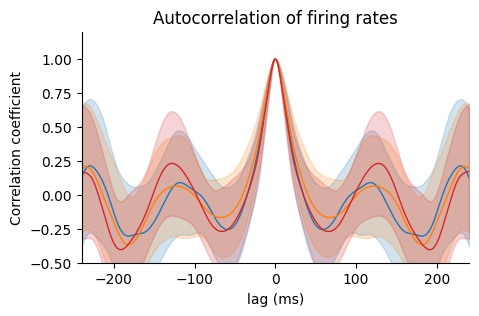

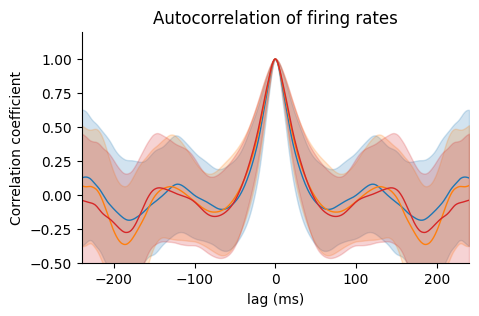

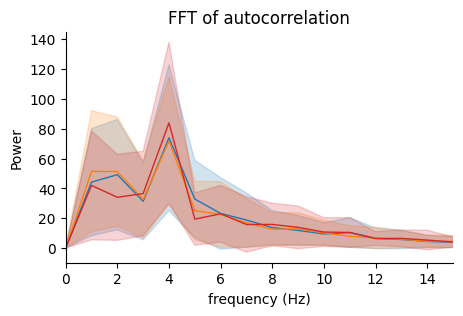

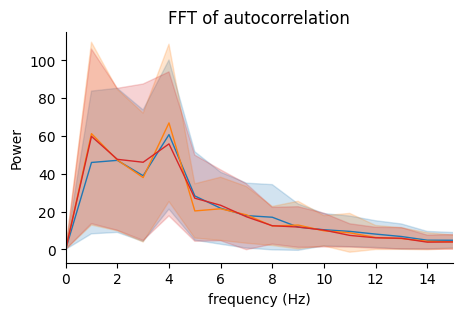

In [291]:
params = set_params(tt_preset='merge',
                         bt_preset='basic',
                         len_pos_average=10,
                         gaussian_range=20,
                         gaussian_sigma=20)

extract_dir = "../../data/flexible_shift/"

run_on(extract_dir, params, "pattern", "position", 3)

minimum firing: 3
legal num: 731
total num: 1037
legal ratio: 0.7049180327868853
3Hz num: 188
3hz ratio: 0.25718194254445964


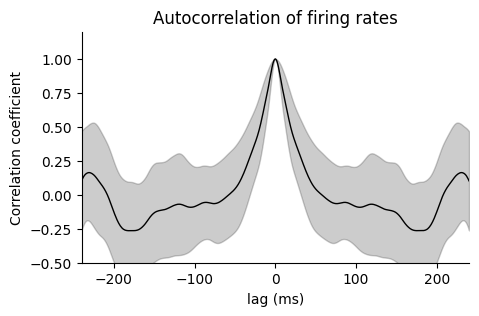

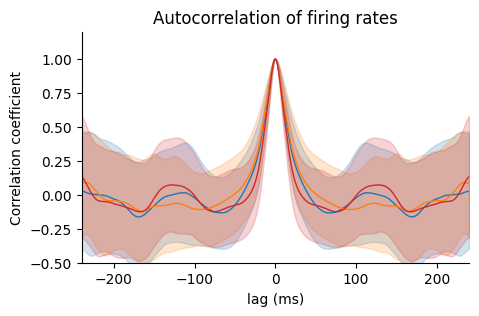

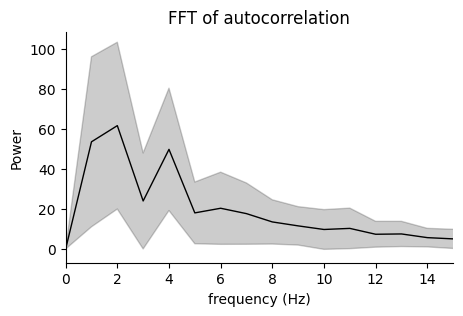

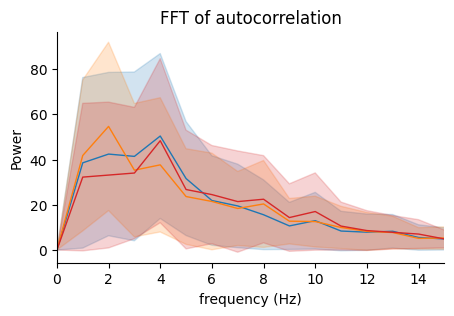

In [294]:
extract_dir = "../../data/first_to_pat"

run_on(extract_dir, params, "origin", "pattern", 3)

minimum firing: 3
legal num: 422
total num: 594
legal ratio: 0.7104377104377104
3Hz num: 130
3hz ratio: 0.3080568720379147


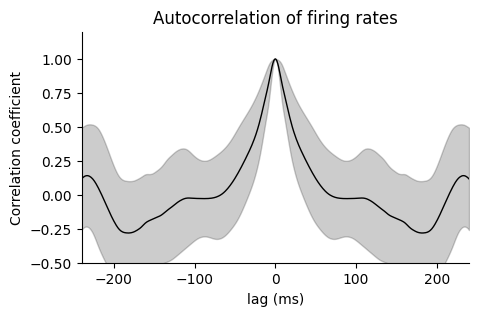

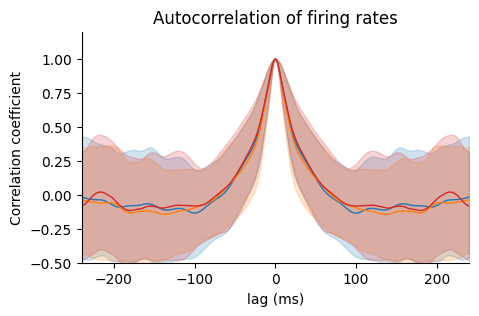

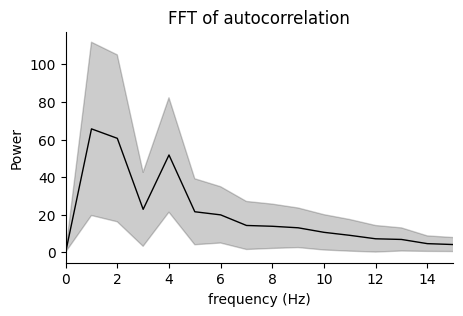

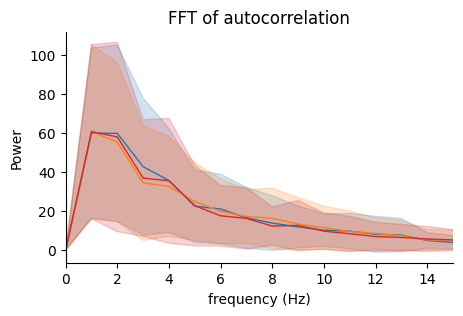

In [293]:
extract_dir = "../../data/first_to_pos"

run_on(extract_dir, params, "origin", "position", 3)